In [ ]:
!nvidia-smi

Sun May 29 17:12:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## <span style='font-family:"Times New Roman"'> Downloading libraries

In [ ]:
!pip install simpletransformers
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 249 kB 8.8 MB/s 
     |████████████████████████████████| 1.8 MB 47.1 MB/s 
     |████████████████████████████████| 43 kB 1.1 MB/s 
     |████████████████████████████████| 6.6 MB 48.0 MB/s 
     |████████████████████████████████| 4.2 MB 52.4 MB/s 
     |████████████████████████████████| 10.1 MB 53.5 MB/s 
     |████████████████████████████████| 1.2 MB 30.0 MB/s 
     |████████████████████████████████| 346 kB 17.6 MB/s 
     |████████████████████████████████| 596 kB 55.4 MB/s 
     |████████████████████████████████| 86 kB 2.6 MB/s 
     |████████████████████████████████| 181 kB 42.3 MB/s 
     |████████████████████████████████| 145 kB 57.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 86 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 51.5 MB/s 
     |████████████████████████████████|

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 34.2 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=ee79612d57dfd148e1fdf3c92960e53cddda977afc8879b407588aef8a643f69
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


## <span style='font-family:"Times New Roman"'>Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import emoji

from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
      
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
"""Muting warnings"""
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

## <span style='font-family:"Times New Roman"'>Importing corpora

In [ ]:
"""Loading data-sets"""
df_train = pd.read_csv("https://www.dropbox.com/s/6gr5t05rd7v3nwm/dalc_v1_train_text.csv?dl=1")
df_dev = pd.read_csv("https://www.dropbox.com/s/mf2gyanb2pbz51a/dalc_v1_dev_text.csv?dl=1")
df_test = pd.read_csv("https://www.dropbox.com/s/ngotr4fyhjl9i2f/dalc_v1_test_text.csv?dl=1")
df_gold = pd.read_csv("https://www.dropbox.com/s/renwwgci14rs97z/df_gold.csv?dl=1")

## <span style='font-family:"Times New Roman"'>Helper functions

In [ ]:
def heatmap(confusion_matrix, labels, color):
    """Create heatmap from confusion matrix"""
    dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap=color, xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label") 
    plt.ylabel("True Label")
    plt.show()

In [ ]:
def avg_confusion(conf_list):
    """Calculate average of multiple confusion matrixes"""
    c1 = conf_list[0]
    c2 = conf_list[1]
    c3 = conf_list[2]
    avg_conf = np.round(np.mean(np.array([c1, c2, c3]), axis=0))
    return avg_conf

In [ ]:
def avg_classification(reports):
    """Calculate average of multiple classification reports"""
    s = []
    loc1 = [54,85,116,152,176,197]
    for l1 in loc1:
        for n in reports:
            n = n.split(' ')
            if n[l1][:3] not in s:
                s.append(n[l1][:3])
            
    n = []
    loc2 = [39,43,47,70,74,78,101,105,109,145,161,165,169,182,186,190]
    sum = 0
    for l2 in loc2:
        for score in reports:
            score = score.split(' ')
            sum += float(score[l2]) 
        avg = sum / len(reports)
        avg = np.round(avg, 4)
        n.append(avg)
        sum = 0   
        
    classification_matrix = "\t\t     precision  recall  f1-score   support\n \
     NOT\t\t{0}\t{1}\t{2}\t     {16}\n \
     IMP\t\t{3}\t{4}\t{5}\t     {17}\n \
     EXP\t\t{6}\t{7}\t{8}\t     {18}\n\n \
     accuracy\t\t\t\t{9}\t     {19}\n \
     macro avg\t\t{10}\t{11}\t{12}\t     {20}\n \
     weighted avg\t{13}\t{14}\t{15}\t     {21}".format(n[0], n[1], n[2], n[3], 
    n[4], n[5], n[6], n[7], n[8], n[9], n[10], n[11], n[12], n[13], n[14], n[15], 
    s[0], s[1], s[2], s[3], s[3], s[3])
    return classification_matrix

## <span style='font-family:"Times New Roman"'>Processing labels & text

In [ ]:
def clean_samples(text):
    """Clean the text of the tweets"""
  new_samples = []
  for tweet_message in text:
      tweet_message = re.sub(r'https.*[^ ]', 'URL', tweet_message)
      tweet_message = re.sub(r'http.*[^ ]', 'URL', tweet_message)
      tweet_message = re.sub(r'@([^ ]*)', '@USER', tweet_message)
      tweet_message = emoji.demojize(tweet_message)
      tweet_message = re.sub(r'(:.*?:)', r' \1 ', tweet_message)
      tweet_message = re.sub(' +', ' ', tweet_message)
      new_samples.append(tweet_message)
  return new_samples

In [ ]:
def encode_labels(labels):
    """Encoding the labels"""
    y_label = []
    for label in labels:
        if label == "EXPLICIT":
            y_label.append(2)
        elif label == "IMPLICIT":
            y_label.append(1)
        elif label == "NOT":
            y_label.append(0)
    return y_label

In [ ]:
"""Droping columns we don't use"""
df_train = df_train.drop(columns = ['Id', 'Target'])
df_dev = df_dev.drop(columns = ['Id', 'Target'])

In [ ]:
"""Converting labels to numerical"""
train_labels = encode_labels(df_train['Explicitness'])
dev_labels = encode_labels(df_dev['Explicitness'])
test_labels = encode_labels(df_test['Explicitness'])
gold_labels = encode_labels(df_gold['Explicitness'])
df_train['Label'] = train_labels
df_dev['Label'] = dev_labels
df_gold['Label'] = gold_labels

In [ ]:
"""Removing old labels"""
train_set = df_train.drop(columns=['Explicitness'])
dev_set = df_dev.drop(columns=['Explicitness'])
gold_set = df_gold.drop(columns=['Explicitness'])

In [ ]:
"""Cleaning the text of the tweets"""
train_set['Text'] = clean_samples(train_set['Text'])
dev_set['Text'] = clean_samples(dev_set['Text'])
gold_set['Text'] = clean_samples(gold_set['Text'])

In [ ]:
train_set

,Text,Label
0,a1 limburgsingel arnhem 6845DS 79898 | Ambulan...,0
1,Schijnt trouwens dat er in België ook verdacht...,0
2,@USER Zo lijkt het bij sommige mensen écht hé?,0
3,Vannacht is deze trailer gestolen van het terr...,0
4,"@USER ik geen eeuwige grafrust, die lui ook ni...",0
...,...,...
5701,Netherlands is ook weer niet zo heel anders to...,0
5702,RT @USER #nieuwstwitter 'Hazard bezig aan laat...,0
5703,@USER @USER Dresscode #demonstratie #DenHaag S...,1
5704,@USER ... APEN STELEN CORONA BLOEDMONSTERS IN ...,0


In [ ]:
dev_set


,Text,Label
0,"@USER @USER Verder al veldwerk dat WBE's doen,...",0
1,@USER Het extreem linkse CNN wordt belaagd doo...,0
2,@USER @USER en eindeloze hoeveelheden papiersc...,0
3,@USER @USER @USER @USER Ik denk dat de grootst...,0
4,"Als je ""protesteert"" tegen politiegeweld en da...",0
...,...,...
544,@USER Een walgelijk beeld. :nauseated_face:,0
545,@USER @USER @USER Wat trap jij er makkelijk in...,0
546,Boze eigenaren van privé sauna’s willen eerder...,0
547,@USER Marijnissen verwijt groei populisme door...,0


In [ ]:
gold_set

,Text,Label
0,"#eventothier Grote smurf, Mark Rutte met zijn ...",1
1,@USER @USER Ik heb de debatten gisteren over d...,1
2,@USER Want? Welk feit klopt er niet?,0
3,@USER @USER @USER @USER @USER gestoord mens....,2
4,@USER @USER @USER @USER de keuze had ik al gem...,0
...,...,...
994,"@USER @USER @USER Jij woont in Leiden, Eva. In...",1
995,@USER is een sukkel. Zelfs in China zien ze dat.,0
996,@USER @USER Die absentielijsten kun je gewoon ...,1
997,@USER @USER @USER Absoluut. Betrokken en integer.,0


In [ ]:
"""Storing test text and labels seperatly"""
y_test = []
for label in gold_set['Label']:
    y_test.append(label)

x_test = []
for text in gold_set['Text']:
    x_test.append(text)

## <span style='font-family:"Times New Roman"'>Setup functions

In [ ]:
def train_evaluate(model, args):
    """Train and evaulue the bert model,
    taks as input the ClassificationModel(), 
    and ClassificationArgs()"""
    print("Training and evaluating model: {}".format(model['name']))

    model_args = ClassificationArgs(num_train_epochs=args['epochs'], 
                                    overwrite_output_dir=args['overwrite_output'],
                                    learning_rate=model['learn_rate'],
                                    train_batch_size=model['train_batch_size'],
                                    do_lower_case=args['do_lower_case'])

    model = ClassificationModel(model['type'],
                                model['model'],
                                num_labels=3,
                                args=model_args, 
                                use_cuda=True) 
    
    metrics = {
        'accuracy': accuracy_score,
        'all': classification_report,
    }

    model.train_model(train_set)
    results, model_output, wrong_predictions = model.eval_model(dev_set, **metrics)
    print(results['all'])
    pred, raw_output = model.predict(x_test)

    report = classification_report(y_test, pred, digits=4, output_dict=False)
    confusion = confusion_matrix(y_test, pred)
   
    print(report)
    return report, confusion

In [ ]:
def finetuning(model, args):
    """Takes the saem arguments as train_evaluate,
    but only returns the results on the development set"""
    print("Training and evaluating model: {}".format(model['name']))
   
    model_args = ClassificationArgs(num_train_epochs=args['epochs'], 
                                    overwrite_output_dir=args['overwrite_output'],
                                    learning_rate=model['learn_rate'],
                                    train_batch_size=model['train_batch_size'],
                                    do_lower_case=args['do_lower_case'])

    metrics = {
        'accuracy': accuracy_score,
        'all': classification_report,
    }

    model = ClassificationModel(model['type'],
                                model['model'],
                                num_labels=3,
                                args=model_args, 
                                use_cuda=True) 
    
    model.train_model(train_set)
    results, model_outputs, wrong_pred = model.eval_model(dev_set, **metrics)
    print(results['all'])
    return results

## <span style='font-family:"Times New Roman"'>Finale models

In [ ]:
"""Final BERT models"""

# BERTje baseline 
BERTje_base = {
    'name': 'BERTje baseline',
    'model': 'GroNLP/bert-base-dutch-cased',
    'type': 'bert',
    'learn_rate': 4e-5,       #default
    'train_batch_size': 8,    #default 
}

BERTje_base_args = {
    'epochs': 2,
    'overwrite_output': True,
}

# BERTje finetuned
BERTje_finetuned = {
    'name': 'BERTje finetuned',
    'model': 'GroNLP/bert-base-dutch-cased',
    'type': 'bert',
    'learn_rate': 6e-5,
    'train_batch_size': 16,
}

BERTje_finetuned_args = {
    'epochs': 4,
    'overwrite_output': True,
    'do_lower_case': False,
}

# RobBERT baseline
RobBERT_base = {
    'name': 'RobBERT baseline',
    'model': 'pdelobelle/robbert-v2-dutch-base',
    'type': 'roberta',
    'learn_rate': 4e-5,      #default
    'train_batch_size': 8,   #default
}

RobBERT_base_args = {
    'epochs': 2,
    'overwrite_output': True,
}

# RobBERT finetuned
RobBERT_finetuned = {
    'name': 'RobBERT finetuned',
    'model': 'pdelobelle/robbert-v2-dutch-base',
    'type': 'roberta',
    'learn_rate': 3e-5,
    'train_batch_size': 16,
}

RobBERT_finetuned_args = {
    'epochs': 3,
    'overwrite_output': True,
    'do_lower_case': True,
}

In [ ]:
"""BERTje baseline"""
bertje_base_classif = []
bertje_base_conf = []  
for run in range(3):
    model = train_evaluate(BERTje_base, BERTje_base_args)
    bertje_base_classif.append(model[0])
    bertje_base_conf.append(model[1])

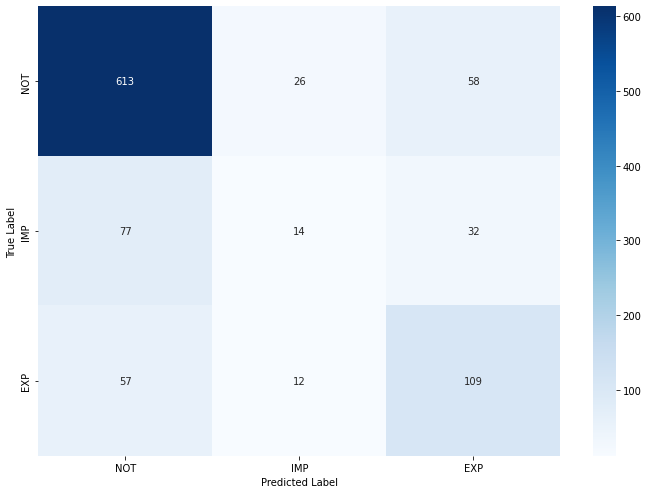

In [ ]:
"""
BERTje baseline 
Results: epochs: 2 
         learn rate: 4e-5 (default)
         train batch size: 8 (default)

Avg confusion:
[[613.  26.  58.]
 [ 77.  14.  32.]
 [ 57.  12. 109.]]

Run 1:
              precision    recall  f1-score   support

           0     0.8144    0.9067    0.8581       697
           1     0.3438    0.0887    0.1410       124
           2     0.5707    0.6124    0.5908       178

    accuracy                         0.7528       999
   macro avg     0.5763    0.5359    0.5300       999
weighted avg     0.7126    0.7528    0.7215       999

Run 2:
              precision    recall  f1-score   support

           0     0.8184    0.8924    0.8538       697
           1     0.3243    0.0968    0.1491       124
           2     0.5545    0.6292    0.5895       178

    accuracy                         0.7467       999
   macro avg     0.5657    0.5395    0.5308       999
weighted avg     0.7101    0.7467    0.7192       999

Run 3:
              precision    recall  f1-score   support

           0     0.8286    0.8393    0.8339       697
           1     0.2222    0.1613    0.1869       124
           2     0.5172    0.5899    0.5512       178

    accuracy                         0.7107       999
   macro avg     0.5227    0.5302    0.5240       999
weighted avg     0.6979    0.7107    0.7032       999

Average 3 run:

              precision    recall  f1-score   support
              
NOT              0.8205    0.8795    0.8486       697
IMP              0.2968    0.1156    0.1590       124
EXP              0.5475    0.6105    0.5772       178

accuracy                             0.7367       999
macro avg        0.5549    0.5352    0.5283       999
weighted avg     0.7069    0.7367    0.7146       999
"""

avg_conf = avg_confusion(bertje_base_conf)
#print(avg_conf)
labels = ["NOT", "IMP", "EXP"]
heatmap(avg_conf, labels, "Blues")
#[print(n) for n in bertje_base_classif]
#print(avg_classification(bertje_base_classif))

In [ ]:
"""BERTje finetuned"""
bertje_tuned_classif = []
bertje_tuned_conf = []  
for run in range(3):
    model = train_evaluate(BERTje_finetuned, BERTje_finetuned_args)
    bertje_tuned_classif.append(model[0])
    bertje_tuned_conf.append(model[1])

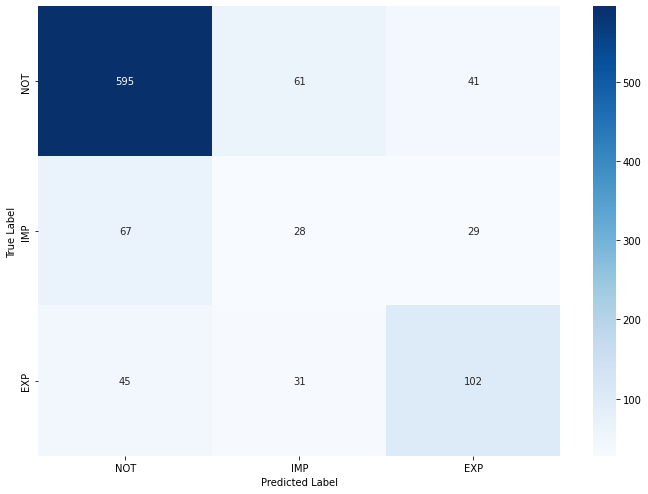

In [ ]:
"""
BERTje finetuned 
Results:    epochs: 4 
            learn rate: 6e-5 
            train batch size: 16 


average confusion:
[[595.  61.  41.]
 [ 67.  28.  29.]
 [ 45.  31. 102.]]

Run 1:
              precision    recall  f1-score   support

           0     0.8557    0.8422    0.8489       697
           1     0.2483    0.2903    0.2677       124
           2     0.6071    0.5730    0.5896       178

    accuracy                         0.7257       999
   macro avg     0.5704    0.5685    0.5687       999
weighted avg     0.7360    0.7257    0.7305       999

Run 2:
              precision    recall  f1-score   support

           0     0.8320    0.8666    0.8489       697
           1     0.1905    0.1613    0.1747       124
           2     0.5833    0.5506    0.5665       178

    accuracy                         0.7227       999
   macro avg     0.5353    0.5261    0.5300       999
weighted avg     0.7080    0.7227    0.7149       999

Run 3:
              precision    recall  f1-score   support

           0     0.8390    0.8522    0.8456       697
           1     0.2569    0.2258    0.2403       124
           2     0.5879    0.6011    0.5944       178

    accuracy                         0.7297       999
   macro avg     0.5613    0.5597    0.5601       999
weighted avg     0.7220    0.7297    0.7257       999

Average 3 run:

              precision    recall  f1-score   support
              
NOT              0.8422    0.8537    0.8478       697
IMP              0.2319    0.2258    0.2276       124
EXP              0.5928    0.5749    0.5835       178

accuracy                             0.7260       999
macro avg        0.5557    0.5514    0.5529       999
weighted avg     0.7220    0.7260    0.7237       999
"""


avg_conf3 = avg_confusion(bertje_tuned_conf)
#print(avg_conf3)
labels3 = ["NOT", "IMP", "EXP"]
heatmap(avg_conf3, labels3, "Blues")
#[print(n) for n in bertje_tuned_classif]
#print(avg_classification(bertje_tuned_classif))

In [ ]:
"""RobBERT baseline"""
robert_base_classif = []
robert_base_conf = []  
for run in range(3):
    model = train_evaluate(RobBERT_base, RobBERT_base_args)
    robert_base_classif.append(model[0])
    robert_base_conf.append(model[1])

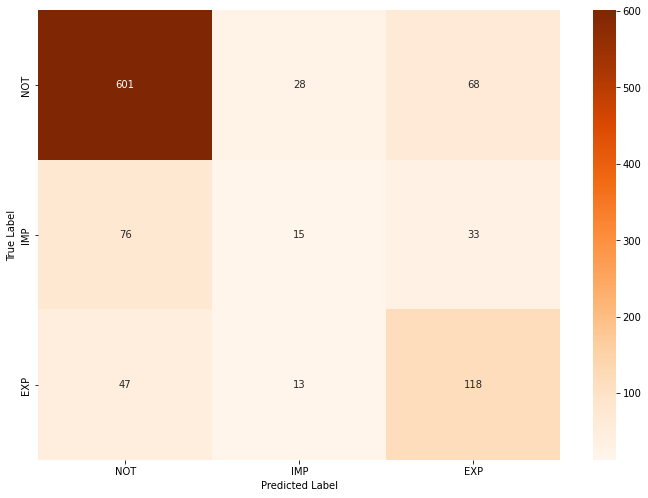

In [ ]:
"""
RobBERT baseline 
Results:   epoch: 2 
           learn rate: 4e-5 (default)
           train batch size: 8 (default)

average confusion:
[[601.  28.  68.]
 [ 76.  15.  33.]
 [ 47.  13. 118.]]

Run 1:
              precision    recall  f1-score   support

           0     0.8313    0.8694    0.8499       697
           1     0.2642    0.1129    0.1582       124
           2     0.5392    0.6573    0.5924       178

    accuracy                         0.7377       999
   macro avg     0.5449    0.5465    0.5335       999
weighted avg     0.7088    0.7377    0.7182       999

Run 2:
              precision    recall  f1-score   support

           0     0.8246    0.8766    0.8498       697
           1     0.3226    0.0806    0.1290       124
           2     0.5330    0.6798    0.5975       178

    accuracy                         0.7427       999
   macro avg     0.5601    0.5457    0.5255       999
weighted avg     0.7103    0.7427    0.7154       999

Run 3:
              precision    recall  f1-score   support

           0     0.8336    0.8407    0.8371       697
           1     0.2500    0.1694    0.2019       124
           2     0.5425    0.6461    0.5897       178

    accuracy                         0.7227       999
   macro avg     0.5420    0.5521    0.5429       999
weighted avg     0.7093    0.7227    0.7142       999

Average 3 run:

              precision    recall  f1-score   support
              
NOT              0.8298    0.8622    0.8456       697
IMP              0.2789    0.1210    0.1630       124
EXP              0.5382    0.6611    0.5932       178

accuracy                             0.7344       999
macro avg        0.5490    0.5481    0.5340       999
weighted avg     0.7095    0.7344    0.7159       999
"""

avg_conf1 = avg_confusion(robert_base_conf)
#print(avg_conf1)
labels1 = ["NOT", "IMP", "EXP"]
heatmap(avg_conf1, labels1, "Oranges")
#[print(n) for n in robert_base_classif]
#print(avg_classification(robert_base_classif))

In [ ]:
"""RobBERT finetuned"""
robbert_finetuned_classif = []
robbert_finetuned_conf = []  
for run in range(3):
    model = train_evaluate(RobBERT_finetuned, RobBERT_finetuned_args)
    robbert_finetuned_classif.append(model[0])
    robbert_finetuned_conf.append(model[1])

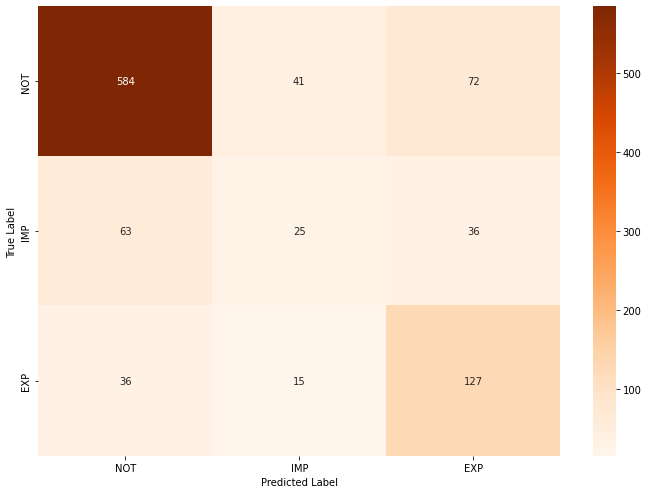

In [ ]:
"""
RobBERT finetuned 
Results:   epochs: 3 
           learn rate: 3e-5 
           train batch size: 16 

average confusion:
[[584.  41.  72.]
 [ 63.  25.  36.]
 [ 36.  15. 127.]]


Average 3 run:

Run 1:
              precision    recall  f1-score   support

           0     0.8565    0.8393    0.8478       697
           1     0.3226    0.2419    0.2765       124
           2     0.5740    0.7191    0.6384       178

    accuracy                         0.7437       999
   macro avg     0.5844    0.6001    0.5876       999
weighted avg     0.7399    0.7437    0.7396       999

Run 2:
              precision    recall  f1-score   support

           0     0.8480    0.8407    0.8444       697
           1     0.3077    0.1613    0.2116       124
           2     0.5226    0.7135    0.6033       178

    accuracy                         0.7337       999
   macro avg     0.5595    0.5718    0.5531       999
weighted avg     0.7230    0.7337    0.7229       999

Run 3:
              precision    recall  f1-score   support

           0     0.8607    0.8336    0.8469       697
           1     0.2874    0.2016    0.2370       124
           2     0.5274    0.7022    0.6024       178

    accuracy                         0.7317       999
   macro avg     0.5585    0.5791    0.5621       999
weighted avg     0.7302    0.7317    0.7277       999

Average 3 run:

              precision    recall  f1-score   support

NOT              0.8551    0.8379    0.8464       697
IMP              0.3059    0.2016    0.2417       124
EXP              0.5413    0.7116    0.6147       178

accuracy                             0.7364       999
macro avg        0.5675    0.5837    0.5676       999
weighted avg     0.7310    0.7364    0.7301       999
"""


avg_conf2 = avg_confusion(robbert_finetuned_conf)
#print(avg_conf2)
labels2 = ["NOT", "IMP", "EXP"]
heatmap(avg_conf2, labels2, "Oranges")
#[print(n) for n in robbert_finetuned_classif]
#print(avg_classification(robbert_finetuned_classif))

## Finetuning process

In [ ]:
"""Best parameters from the first run of 16 runs, 4 x 4 parameters
learning rate: 2e-5, 3e-5, 5e-5, 6e-5
batch size:    4, 8, 16, 32

bf = bert finetuned
bfa = bert finetuned args

BERTje"""

bf1 = {
    'name': 'BERTje finetuned',
    'model': 'GroNLP/bert-base-dutch-cased',
    'type': 'bert',
    'learn_rate': 2e-5,
    'train_batch_size': 32,
}

bfa1 = {
    'epochs': 4,
    'overwrite_output': True,
    'do_lower_case': False,
}

bf2 = {
    'name': 'BERTje finetuned',
    'model': 'GroNLP/bert-base-dutch-cased',
    'type': 'bert',
    'learn_rate': 2e-5,
    'train_batch_size': 32,
}

bfa2 = {
    'epochs': 3,
    'overwrite_output': True,
    'do_lower_case': False,
}

bf3 = {
    'name': 'BERTje finetuned',
    'model': 'GroNLP/bert-base-dutch-cased',
    'type': 'bert',
    'learn_rate': 2e-5,
    'train_batch_size': 16,
}

bfa3 = {
    'epochs': 4,
    'overwrite_output': True,
    'do_lower_case': False,
}

bf4 = {
    'name': 'BERTje finetuned',
    'model': 'GroNLP/bert-base-dutch-cased',
    'type': 'bert',
    'learn_rate': 2e-5,
    'train_batch_size': 16,
}

bfa4 = {
    'epochs': 3,
    'overwrite_output': True,
    'do_lower_case': False,
}

bf5 = {
    'name': 'BERTje finetuned',
    'model': 'GroNLP/bert-base-dutch-cased',
    'type': 'bert',
    'learn_rate': 2e-5,
    'train_batch_size': 4,
}

bfa5 = {
    'epochs': 4,
    'overwrite_output': True,
    'do_lower_case': False,
}

bf6 = {
    'name': 'BERTje finetuned',
    'model': 'GroNLP/bert-base-dutch-cased',
    'type': 'bert',
    'learn_rate': 2e-5,
    'train_batch_size': 4,
}

bfa6 = {
    'epochs': 3,
    'overwrite_output': True,
    'do_lower_case': False,
}

bf7 = {
    'name': 'BERTje finetuned',
    'model': 'GroNLP/bert-base-dutch-cased',
    'type': 'bert',
    'learn_rate': 6e-5,
    'train_batch_size': 16,
}

bfa7 = {
    'epochs': 3,
    'overwrite_output': True,
    'do_lower_case': False,
}

bf8 = {
    'name': 'BERTje finetuned',
    'model': 'GroNLP/bert-base-dutch-cased',
    'type': 'bert',
    'learn_rate': 6e-5,
    'train_batch_size': 16,
}

bfa8 = {
    'epochs': 4,
    'overwrite_output': True,
    'do_lower_case': False,
}

In [ ]:
"""Best parameters from the first run of 16 models, 4 x 4 parameters
learning rate: 2e-5, 3e-5, 5e-5, 6e-5
batch size:    4, 8, 16, 32

rbf = robbert finetuned
rbfa = robbert finetuned args

RobBERT"""

rbf1 = {
    'name': 'RobBERT finetuned',
    'model': 'pdelobelle/robbert-v2-dutch-base',
    'type': 'roberta',
    'learn_rate': 3e-5,
    'train_batch_size': 16,
}

rbfa1 = {
    'epochs': 4,
    'overwrite_output': True,
    'do_lower_case': True,
}

rbf2 = {
    'name': 'RobBERT finetuned',
    'model': 'pdelobelle/robbert-v2-dutch-base',
    'type': 'roberta',
    'learn_rate': 3e-5,
    'train_batch_size': 16,
}

rbfa2 = {
    'epochs': 3,
    'overwrite_output': True,
    'do_lower_case': True,
}

rbf3 = {
    'name': 'RobBERT finetuned',
    'model': 'pdelobelle/robbert-v2-dutch-base',
    'type': 'roberta',
    'learn_rate': 3e-5,
    'train_batch_size': 8,
}

rbfa3 = {
    'epochs': 4,
    'overwrite_output': True,
    'do_lower_case': True,
}

rbf4 = {
    'name': 'RobBERT finetuned',
    'model': 'pdelobelle/robbert-v2-dutch-base',
    'type': 'roberta',
    'learn_rate': 3e-5,
    'train_batch_size': 8,
}

rbfa4 = {
    'epochs': 3,
    'overwrite_output': True,
    'do_lower_case': True,
}

rbf5 = {
    'name': 'RobBERT finetuned',
    'model': 'pdelobelle/robbert-v2-dutch-base',
    'type': 'roberta',
    'learn_rate': 3e-5,
    'train_batch_size': 4,
}

rbfa5 = {
    'epochs': 4,
    'overwrite_output': True,
    'do_lower_case': True,
}

rbf6 = {
    'name': 'RobBERT finetuned',
    'model': 'pdelobelle/robbert-v2-dutch-base',
    'type': 'roberta',
    'learn_rate': 3e-5,
    'train_batch_size': 4,
}

rbfa6 = {
    'epochs': 3,
    'overwrite_output': True,
    'do_lower_case': True,
}

In [ ]:
r1 = []
for n in range(2):
  m1 = finetuning(bf1, bfa1)
  r1.append(m1)

Training and evaluating model: BERTje finetuned


Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/417M [00:00<?, ?B/s]

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

Downloading:   0%|          | 0.00/254 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.553483719573384, 'accuracy': 0.8597449908925319, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.90      0.95      0.92       439\n         1.0       0.40      0.32      0.35        38\n         2.0       0.78      0.62      0.69        72\n\n    accuracy                           0.86       549\n   macro avg       0.69      0.63      0.66       549\nweighted avg       0.85      0.86      0.85       549\n', 'eval_loss': 0.4996868620856085}


              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92       439
         1.0       0.40      0.32      0.35        38
         2.0       0.78      0.62      0.69        72

    accuracy                           0.86       549
   macro avg       0.69      0.63      0.66       549
weighted avg       0.85      0.86      0.85       549

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5022054566566567, 'accuracy': 0.8397085610200364, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.90      0.92      0.91       439\n         1.0       0.30      0.26      0.28        38\n         2.0       0.71      0.62      0.67        72\n\n    accuracy                           0.84       549\n   macro avg       0.64      0.60      0.62       549\nweighted avg       0.83      0.84      0.83       549\n', 'eval_loss': 0.5042209880075593}


              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       439
         1.0       0.30      0.26      0.28        38
         2.0       0.71      0.62      0.67        72

    accuracy                           0.84       549
   macro avg       0.64      0.60      0.62       549
weighted avg       0.83      0.84      0.83       549



In [ ]:
r2 = []
for n in range(2):
  m2 = finetuning(bf2, bfa2)
  r2.append(m2)

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/179 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5168025067005518, 'accuracy': 0.8524590163934426, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.89      0.95      0.92       439\n         1.0       0.44      0.21      0.29        38\n         2.0       0.71      0.61      0.66        72\n\n    accuracy                           0.85       549\n   macro avg       0.68      0.59      0.62       549\nweighted avg       0.83      0.85      0.84       549\n', 'eval_loss': 0.445315089346706}


              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       439
         1.0       0.44      0.21      0.29        38
         2.0       0.71      0.61      0.66        72

    accuracy                           0.85       549
   macro avg       0.68      0.59      0.62       549
weighted avg       0.83      0.85      0.84       549

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/179 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5434255631773253, 'accuracy': 0.8579234972677595, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.90      0.95      0.92       439\n         1.0       0.50      0.21      0.30        38\n         2.0       0.69      0.67      0.68        72\n\n    accuracy                           0.86       549\n   macro avg       0.69      0.61      0.63       549\nweighted avg       0.84      0.86      0.84       549\n', 'eval_loss': 0.4460252320420915}


              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92       439
         1.0       0.50      0.21      0.30        38
         2.0       0.69      0.67      0.68        72

    accuracy                           0.86       549
   macro avg       0.69      0.61      0.63       549
weighted avg       0.84      0.86      0.84       549



In [ ]:
r3 = []
for n in range(2):
  m3 = finetuning(bf3, bfa3)
  r3.append(m3)

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5425610439280498, 'accuracy': 0.8561020036429873, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.90      0.94      0.92       439\n         1.0       0.37      0.26      0.31        38\n         2.0       0.74      0.64      0.69        72\n\n    accuracy                           0.86       549\n   macro avg       0.67      0.62      0.64       549\nweighted avg       0.84      0.86      0.85       549\n', 'eval_loss': 0.5941839401704677}


              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       439
         1.0       0.37      0.26      0.31        38
         2.0       0.74      0.64      0.69        72

    accuracy                           0.86       549
   macro avg       0.67      0.62      0.64       549
weighted avg       0.84      0.86      0.85       549

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5288501679643397, 'accuracy': 0.8451730418943534, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.90      0.92      0.91       439\n         1.0       0.32      0.34      0.33        38\n         2.0       0.78      0.65      0.71        72\n\n    accuracy                           0.85       549\n   macro avg       0.67      0.64      0.65       549\nweighted avg       0.85      0.85      0.84       549\n', 'eval_loss': 0.6038346893113592}


              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       439
         1.0       0.32      0.34      0.33        38
         2.0       0.78      0.65      0.71        72

    accuracy                           0.85       549
   macro avg       0.67      0.64      0.65       549
weighted avg       0.85      0.85      0.84       549



In [ ]:
r4 = []
for n in range(2):
  m4 = finetuning(bf4, bfa4)
  r4.append(m4)

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5191929133691785, 'accuracy': 0.843351548269581, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.90      0.92      0.91       439\n         1.0       0.32      0.32      0.32        38\n         2.0       0.74      0.64      0.69        72\n\n    accuracy                           0.84       549\n   macro avg       0.66      0.63      0.64       549\nweighted avg       0.84      0.84      0.84       549\n', 'eval_loss': 0.5123836635679438}


              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       439
         1.0       0.32      0.32      0.32        38
         2.0       0.74      0.64      0.69        72

    accuracy                           0.84       549
   macro avg       0.66      0.63      0.64       549
weighted avg       0.84      0.84      0.84       549

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5352028399263773, 'accuracy': 0.8524590163934426, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.90      0.94      0.92       439\n         1.0       0.37      0.26      0.31        38\n         2.0       0.71      0.64      0.67        72\n\n    accuracy                           0.85       549\n   macro avg       0.66      0.61      0.63       549\nweighted avg       0.84      0.85      0.84       549\n', 'eval_loss': 0.4824418430958969}


              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       439
         1.0       0.37      0.26      0.31        38
         2.0       0.71      0.64      0.67        72

    accuracy                           0.85       549
   macro avg       0.66      0.61      0.63       549
weighted avg       0.84      0.85      0.84       549



In [ ]:
r5 = []
for n in range(2):
  m5 = finetuning(bf5, bfa5)
  r5.append(m5)

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5124074558258049, 'accuracy': 0.8397085610200364, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.91      0.92      0.92       439\n         1.0       0.26      0.29      0.28        38\n         2.0       0.75      0.61      0.67        72\n\n    accuracy                           0.84       549\n   macro avg       0.64      0.61      0.62       549\nweighted avg       0.84      0.84      0.84       549\n', 'eval_loss': 0.9364057159510212}


              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92       439
         1.0       0.26      0.29      0.28        38
         2.0       0.75      0.61      0.67        72

    accuracy                           0.84       549
   macro avg       0.64      0.61      0.62       549
weighted avg       0.84      0.84      0.84       549

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.515092005812247, 'accuracy': 0.848816029143898, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.89      0.94      0.92       439\n         1.0       0.33      0.26      0.29        38\n         2.0       0.77      0.60      0.67        72\n\n    accuracy                           0.85       549\n   macro avg       0.66      0.60      0.63       549\nweighted avg       0.84      0.85      0.84       549\n', 'eval_loss': 0.8867108659089907}


              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92       439
         1.0       0.33      0.26      0.29        38
         2.0       0.77      0.60      0.67        72

    accuracy                           0.85       549
   macro avg       0.66      0.60      0.63       549
weighted avg       0.84      0.85      0.84       549



In [ ]:
r6 = []
for n in range(2):
  m6 = finetuning(bf6, bfa6)
  r6.append(m6)

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1427 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5675380486352128, 'accuracy': 0.8633879781420765, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.90      0.94      0.92       439\n         1.0       0.36      0.26      0.30        38\n         2.0       0.81      0.69      0.75        72\n\n    accuracy                           0.86       549\n   macro avg       0.69      0.63      0.66       549\nweighted avg       0.85      0.86      0.86       549\n', 'eval_loss': 0.7239962686663088}


              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       439
         1.0       0.36      0.26      0.30        38
         2.0       0.81      0.69      0.75        72

    accuracy                           0.86       549
   macro avg       0.69      0.63      0.66       549
weighted avg       0.85      0.86      0.86       549

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1427 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5698508687018996, 'accuracy': 0.8615664845173042, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.91      0.94      0.92       439\n         1.0       0.43      0.32      0.36        38\n         2.0       0.72      0.68      0.70        72\n\n    accuracy                           0.86       549\n   macro avg       0.69      0.64      0.66       549\nweighted avg       0.85      0.86      0.86       549\n', 'eval_loss': 0.7440107164607532}


              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92       439
         1.0       0.43      0.32      0.36        38
         2.0       0.72      0.68      0.70        72

    accuracy                           0.86       549
   macro avg       0.69      0.64      0.66       549
weighted avg       0.85      0.86      0.86       549



In [ ]:
r7 = []
for n in range(2):
  m7 = finetuning(bf7, bfa7)
  r7.append(m7)

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5223741079233843, 'accuracy': 0.8451730418943534, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.90      0.93      0.92       439\n         1.0       0.30      0.32      0.31        38\n         2.0       0.75      0.60      0.67        72\n\n    accuracy                           0.85       549\n   macro avg       0.65      0.61      0.63       549\nweighted avg       0.84      0.85      0.84       549\n', 'eval_loss': 0.6217628706624543}


              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       439
         1.0       0.30      0.32      0.31        38
         2.0       0.75      0.60      0.67        72

    accuracy                           0.85       549
   macro avg       0.65      0.61      0.63       549
weighted avg       0.84      0.85      0.84       549

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5105866201152451, 'accuracy': 0.8451730418943534, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.89      0.94      0.91       439\n         1.0       0.29      0.32      0.30        38\n         2.0       0.85      0.57      0.68        72\n\n    accuracy                           0.85       549\n   macro avg       0.68      0.61      0.63       549\nweighted avg       0.85      0.85      0.84       549\n', 'eval_loss': 0.6995561256788779}


              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       439
         1.0       0.29      0.32      0.30        38
         2.0       0.85      0.57      0.68        72

    accuracy                           0.85       549
   macro avg       0.68      0.61      0.63       549
weighted avg       0.85      0.85      0.84       549



In [ ]:
r8 = []
for n in range(2):
  m8 = finetuning(bf8, bfa8)
  r8.append(m8)

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.49853682554349615, 'accuracy': 0.8415300546448088, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.89      0.94      0.91       439\n         1.0       0.35      0.37      0.36        38\n         2.0       0.76      0.51      0.61        72\n\n    accuracy                           0.84       549\n   macro avg       0.67      0.61      0.63       549\nweighted avg       0.84      0.84      0.84       549\n', 'eval_loss': 0.8474233067338017}


              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       439
         1.0       0.35      0.37      0.36        38
         2.0       0.76      0.51      0.61        72

    accuracy                           0.84       549
   macro avg       0.67      0.61      0.63       549
weighted avg       0.84      0.84      0.84       549

Training and evaluating model: BERTje finetuned


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.4743099416933055, 'accuracy': 0.8360655737704918, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.89      0.94      0.91       439\n         1.0       0.26      0.24      0.25        38\n         2.0       0.75      0.54      0.63        72\n\n    accuracy                           0.84       549\n   macro avg       0.63      0.57      0.60       549\nweighted avg       0.83      0.84      0.83       549\n', 'eval_loss': 0.8470415585822817}


              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       439
         1.0       0.26      0.24      0.25        38
         2.0       0.75      0.54      0.63        72

    accuracy                           0.84       549
   macro avg       0.63      0.57      0.60       549
weighted avg       0.83      0.84      0.83       549



In [ ]:
r1 = []
for n in range(2):
  m1 = finetuning(rbf1, rbfa1)
  r1.append(m1)

Training and evaluating model: RobBERT finetuned


Downloading:   0%|          | 0.00/446M [00:00<?, ?B/s]

Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.weight', 'cl

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/715k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/374k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5404393105286905, 'accuracy': 0.8524590163934426, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.91      0.94      0.92       439\n         1.0       0.36      0.37      0.36        38\n         2.0       0.75      0.57      0.65        72\n\n    accuracy                           0.85       549\n   macro avg       0.67      0.63      0.64       549\nweighted avg       0.85      0.85      0.85       549\n', 'eval_loss': 0.5476029351137687}


              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92       439
         1.0       0.36      0.37      0.36        38
         2.0       0.75      0.57      0.65        72

    accuracy                           0.85       549
   macro avg       0.67      0.63      0.64       549
weighted avg       0.85      0.85      0.85       549

Training and evaluating model: RobBERT finetuned


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.weight', 'cl

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5243536973091011, 'accuracy': 0.8506375227686703, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.90      0.94      0.92       439\n         1.0       0.31      0.26      0.29        38\n         2.0       0.77      0.60      0.67        72\n\n    accuracy                           0.85       549\n   macro avg       0.66      0.60      0.63       549\nweighted avg       0.84      0.85      0.84       549\n', 'eval_loss': 0.5480628082717675}


              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       439
         1.0       0.31      0.26      0.29        38
         2.0       0.77      0.60      0.67        72

    accuracy                           0.85       549
   macro avg       0.66      0.60      0.63       549
weighted avg       0.84      0.85      0.84       549



In [ ]:
r2 = []
for n in range(2):
  m2 = finetuning(rbf2, rbfa2)
  r2.append(m2)

Training and evaluating model: RobBERT finetuned


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.weight', 'cl

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5863965728330791, 'accuracy': 0.8652094717668488, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.92      0.94      0.93       439\n         1.0       0.40      0.45      0.43        38\n         2.0       0.80      0.62      0.70        72\n\n    accuracy                           0.87       549\n   macro avg       0.71      0.67      0.69       549\nweighted avg       0.87      0.87      0.86       549\n', 'eval_loss': 0.4276025073899739}


              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       439
         1.0       0.40      0.45      0.43        38
         2.0       0.80      0.62      0.70        72

    accuracy                           0.87       549
   macro avg       0.71      0.67      0.69       549
weighted avg       0.87      0.87      0.86       549

Training and evaluating model: RobBERT finetuned


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.weight', 'cl

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5624080432491066, 'accuracy': 0.8524590163934426, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.92      0.92      0.92       439\n         1.0       0.36      0.34      0.35        38\n         2.0       0.71      0.72      0.72        72\n\n    accuracy                           0.85       549\n   macro avg       0.66      0.66      0.66       549\nweighted avg       0.85      0.85      0.85       549\n', 'eval_loss': 0.4449713098398153}


              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       439
         1.0       0.36      0.34      0.35        38
         2.0       0.71      0.72      0.72        72

    accuracy                           0.85       549
   macro avg       0.66      0.66      0.66       549
weighted avg       0.85      0.85      0.85       549



In [ ]:
r3 = []
for n in range(2):
  m3 = finetuning(rbf3, rbfa3)
  r3.append(m3)

Training and evaluating model: RobBERT finetuned


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.weight', 'cl

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/714 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/714 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/714 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/714 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5097083439817354, 'accuracy': 0.8451730418943534, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.90      0.94      0.92       439\n         1.0       0.25      0.21      0.23        38\n         2.0       0.78      0.62      0.69        72\n\n    accuracy                           0.85       549\n   macro avg       0.64      0.59      0.61       549\nweighted avg       0.84      0.85      0.84       549\n', 'eval_loss': 0.7033585116479789}


              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       439
         1.0       0.25      0.21      0.23        38
         2.0       0.78      0.62      0.69        72

    accuracy                           0.85       549
   macro avg       0.64      0.59      0.61       549
weighted avg       0.84      0.85      0.84       549

Training and evaluating model: RobBERT finetuned


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.weight', 'cl

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/714 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/714 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/714 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/714 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5475794530719644, 'accuracy': 0.8542805100182149, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.91      0.94      0.92       439\n         1.0       0.31      0.32      0.31        38\n         2.0       0.79      0.61      0.69        72\n\n    accuracy                           0.85       549\n   macro avg       0.67      0.62      0.64       549\nweighted avg       0.85      0.85      0.85       549\n', 'eval_loss': 0.6983185538353965}


              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92       439
         1.0       0.31      0.32      0.31        38
         2.0       0.79      0.61      0.69        72

    accuracy                           0.85       549
   macro avg       0.67      0.62      0.64       549
weighted avg       0.85      0.85      0.85       549



In [ ]:
r4 = []
for n in range(2):
  m4 = finetuning(rbf4, rbfa4)
  r4.append(m4)

Training and evaluating model: RobBERT finetuned


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.weight', 'cl

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/714 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/714 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/714 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5714863679550773, 'accuracy': 0.8579234972677595, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.91      0.93      0.92       439\n         1.0       0.32      0.32      0.32        38\n         2.0       0.79      0.72      0.75        72\n\n    accuracy                           0.86       549\n   macro avg       0.67      0.66      0.66       549\nweighted avg       0.86      0.86      0.86       549\n', 'eval_loss': 0.5231660531928249}


              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       439
         1.0       0.32      0.32      0.32        38
         2.0       0.79      0.72      0.75        72

    accuracy                           0.86       549
   macro avg       0.67      0.66      0.66       549
weighted avg       0.86      0.86      0.86       549

Training and evaluating model: RobBERT finetuned


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.weight', 'cl

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/714 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running Epoch 1 of 3:   0%|          | 0/714 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/714 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.575656847989858, 'accuracy': 0.8633879781420765, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.91      0.94      0.93       439\n         1.0       0.35      0.34      0.35        38\n         2.0       0.81      0.65      0.72        72\n\n    accuracy                           0.86       549\n   macro avg       0.69      0.65      0.67       549\nweighted avg       0.86      0.86      0.86       549\n', 'eval_loss': 0.5684307690952783}


              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       439
         1.0       0.35      0.34      0.35        38
         2.0       0.81      0.65      0.72        72

    accuracy                           0.86       549
   macro avg       0.69      0.65      0.67       549
weighted avg       0.86      0.86      0.86       549



In [ ]:
r5 = []
for n in range(2):
  m5 = finetuning(rbf5, rbfa5)
  r5.append(m5)

Training and evaluating model: RobBERT finetuned


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.weight', 'cl

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5563285018734162, 'accuracy': 0.8579234972677595, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.91      0.94      0.92       439\n         1.0       0.30      0.26      0.28        38\n         2.0       0.79      0.67      0.72        72\n\n    accuracy                           0.86       549\n   macro avg       0.67      0.62      0.64       549\nweighted avg       0.85      0.86      0.85       549\n', 'eval_loss': 0.8159688962539118}


              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92       439
         1.0       0.30      0.26      0.28        38
         2.0       0.79      0.67      0.72        72

    accuracy                           0.86       549
   macro avg       0.67      0.62      0.64       549
weighted avg       0.85      0.86      0.85       549

Training and evaluating model: RobBERT finetuned


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.weight', 'cl

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1427 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5729524512784134, 'accuracy': 0.8633879781420765, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.91      0.94      0.93       439\n         1.0       0.38      0.29      0.33        38\n         2.0       0.75      0.68      0.72        72\n\n    accuracy                           0.86       549\n   macro avg       0.68      0.64      0.66       549\nweighted avg       0.85      0.86      0.86       549\n', 'eval_loss': 0.8115289534351019}


              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       439
         1.0       0.38      0.29      0.33        38
         2.0       0.75      0.68      0.72        72

    accuracy                           0.86       549
   macro avg       0.68      0.64      0.66       549
weighted avg       0.85      0.86      0.86       549



In [ ]:
r6 = []
for n in range(2):
  m6 = finetuning(rbf6, rbfa6)
  r6.append(m6)

Training and evaluating model: RobBERT finetuned


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.weight', 'cl

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1427 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5620708563054028, 'accuracy': 0.8597449908925319, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.91      0.94      0.92       439\n         1.0       0.33      0.29      0.31        38\n         2.0       0.79      0.67      0.72        72\n\n    accuracy                           0.86       549\n   macro avg       0.68      0.63      0.65       549\nweighted avg       0.85      0.86      0.85       549\n', 'eval_loss': 0.7059658937699472}


              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92       439
         1.0       0.33      0.29      0.31        38
         2.0       0.79      0.67      0.72        72

    accuracy                           0.86       549
   macro avg       0.68      0.63      0.65       549
weighted avg       0.85      0.86      0.85       549

Training and evaluating model: RobBERT finetuned


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.out_proj.weight', 'cl

  0%|          | 0/5706 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1427 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1427 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/549 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/69 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5657127671708412, 'accuracy': 0.8615664845173042, 'all': '              precision    recall  f1-score   support\n\n         0.0       0.91      0.95      0.93       439\n         1.0       0.32      0.24      0.27        38\n         2.0       0.75      0.68      0.72        72\n\n    accuracy                           0.86       549\n   macro avg       0.66      0.62      0.64       549\nweighted avg       0.85      0.86      0.85       549\n', 'eval_loss': 0.6656961983535439}


              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       439
         1.0       0.32      0.24      0.27        38
         2.0       0.75      0.68      0.72        72

    accuracy                           0.86       549
   macro avg       0.66      0.62      0.64       549
weighted avg       0.85      0.86      0.85       549

